In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import warnings
warnings.filterwarnings('ignore')
import sys

In [2]:
pd.set_option('display.max_columns',10000)
pd.set_option('display.max_rows',10000)
np.set_printoptions(threshold=sys.maxsize)

In [3]:
df=pd.read_csv('smart_phone.csv')

In [4]:
df=df.drop(columns = ['Unnamed: 0'],axis='columns')
df.drop(['Android_version','Processor_series','Name','Rating','Spec_score'],axis=1,inplace=True)
df['Processor_']=df['Processor_'].replace('sc9863a','unisoc')
df=df[~df.Processor_.isin(['octa','other'])]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 0 to 1369
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Dual Sim              1364 non-null   int64  
 1   VoLTE                 1364 non-null   int64  
 2   5G                    1364 non-null   int64  
 3   Vo5G                  1364 non-null   int64  
 4   Ram                   1364 non-null   float64
 5   Battery               1364 non-null   int64  
 6   Display               1364 non-null   float64
 7   Foldable Display      1364 non-null   int64  
 8   Dual Display          1364 non-null   int64  
 9   External_Memory       903 non-null    float64
 10  Price                 1364 non-null   int64  
 11  company               1364 non-null   object 
 12  Inbuilt_memory        1346 non-null   float64
 13  fast_charging         1280 non-null   float64
 14  Water Drop Notch      1364 non-null   int64  
 15  with Punch Hole       1364

### missing value in External memory and inbuilt memory and fast charging and processor series

In [6]:
#removing outliear
df=df[df.Price<200000]
df=df[df.Battery<7000]

In [7]:
df.External_Memory.fillna(0,inplace=True)
fast_c=df.groupby('company')['fast_charging'].agg(lambda x: stats.mode(x)).apply(lambda x : x[0]).to_dict()
for i in fast_c:
    df.loc[df.company==i,'fast_charging']=df.loc[df.company==i,'fast_charging'].fillna(fast_c[i])
df=df.dropna()

In [8]:
# convert small company in other
temp=df.company.value_counts().reset_index()
l=temp[temp['count']<15]['company'].to_list()
df.company.replace(l,'other',inplace=True)

In [9]:
# add new column  PPI
df['pixal_D']=np.sqrt(df['V px']**2+df['H px']**2)
df['PPI']=np.sqrt(df['V px']**2+df['H px']**2)/df.Display
df=df.drop(['V px','H px','Display'],axis=1)

In [10]:
col=df.columns.to_list()
n_col=['Battery','Price','fast_charging','Primary_rear_camera','Primary_front_camera','PPI','pixal_D']
for r in n_col:
    col.remove(r)

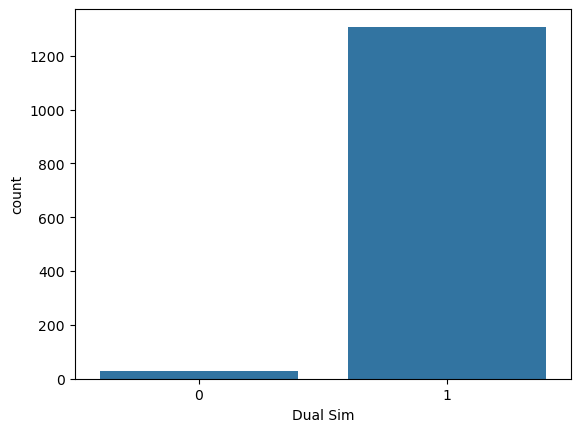

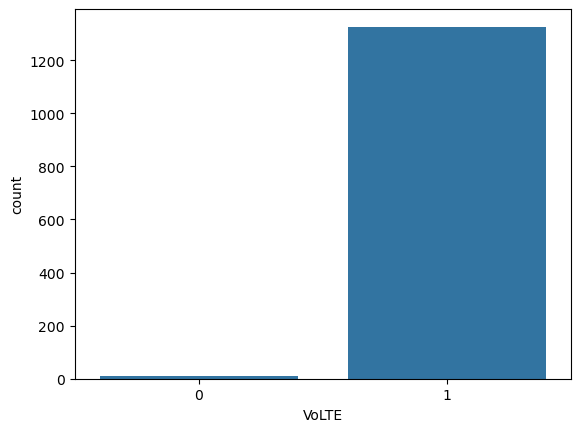

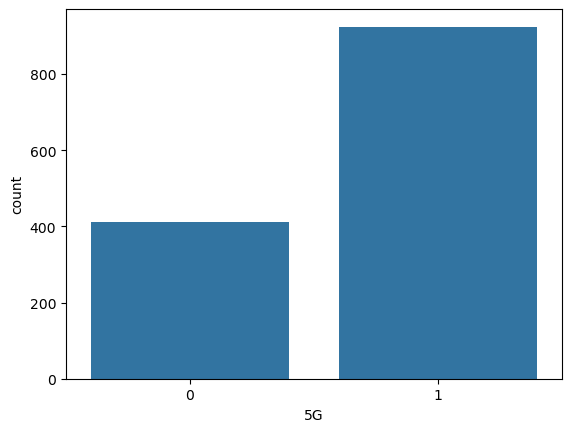

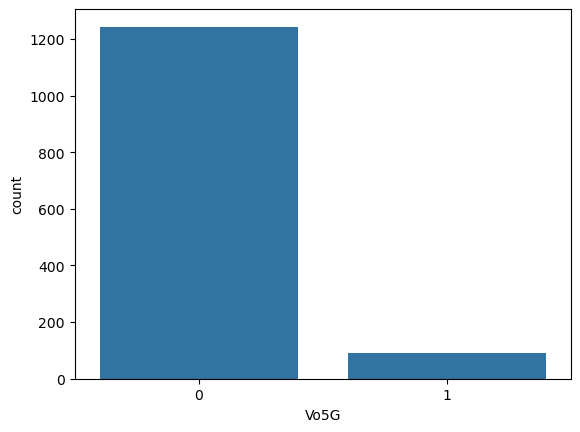

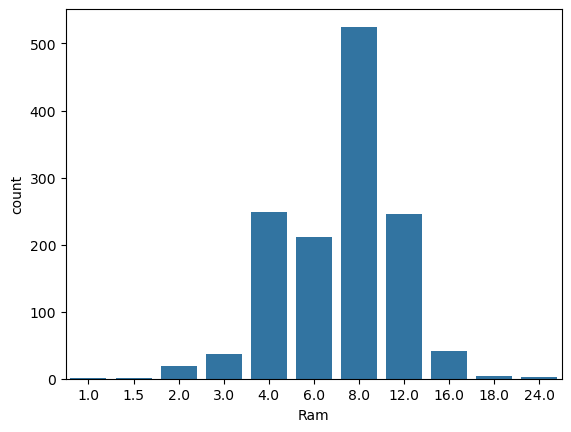

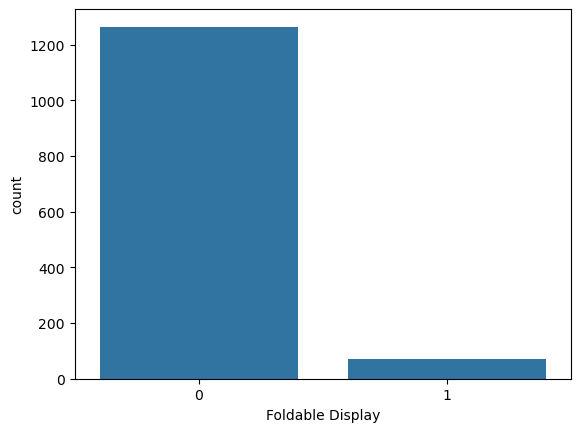

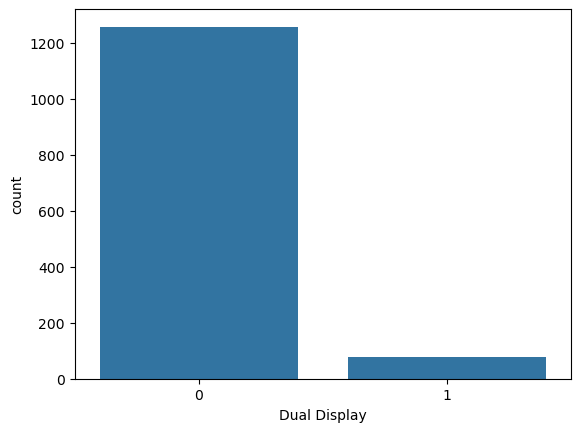

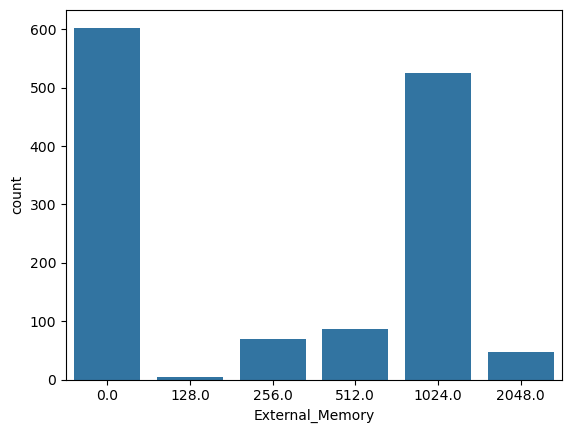

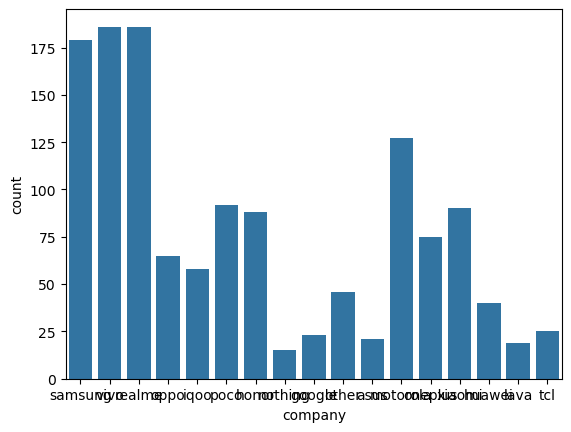

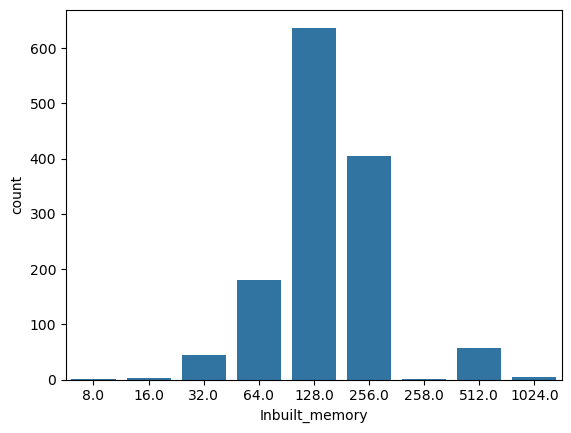

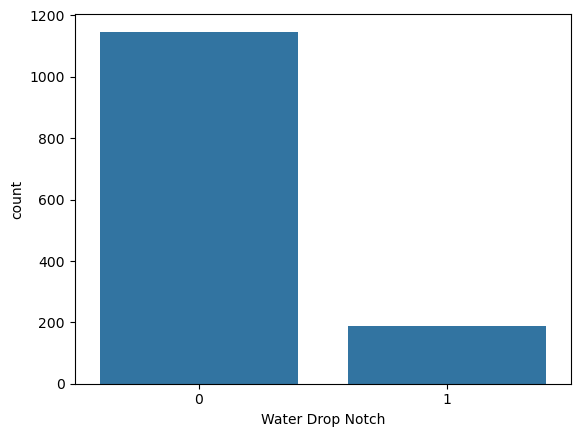

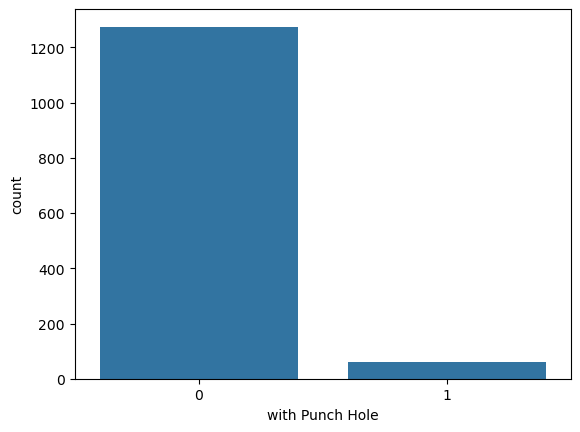

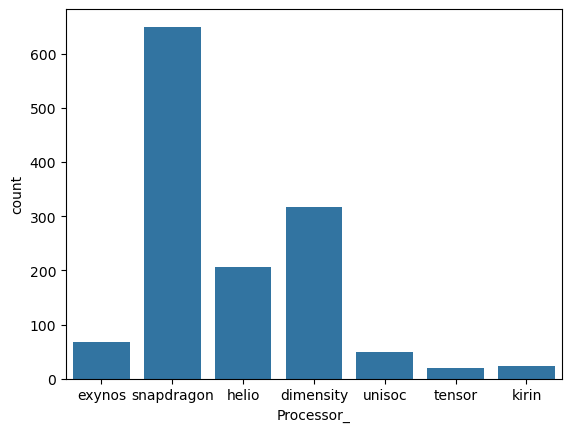

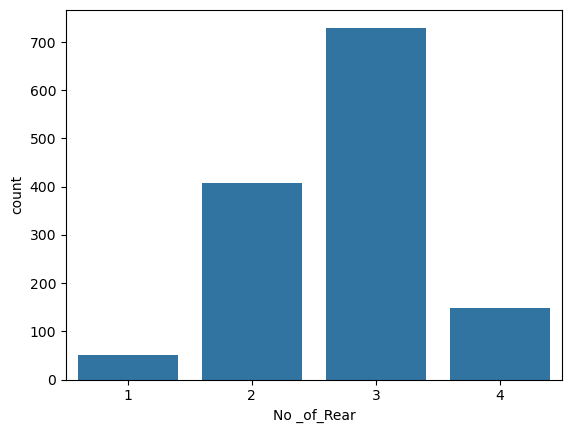

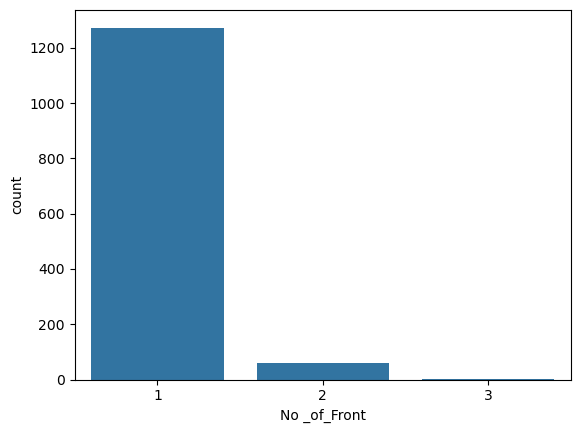

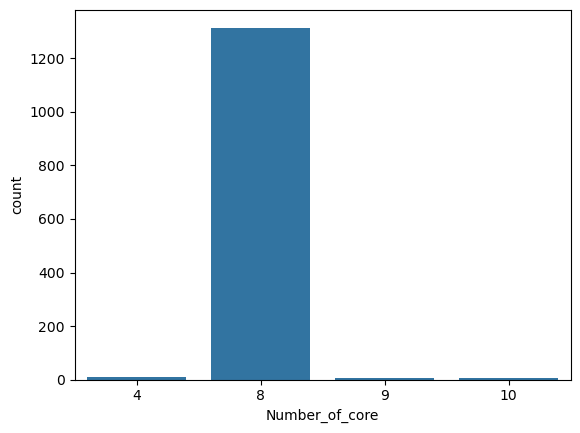

In [11]:
for i in col:
    sns.countplot(df,x=i)
    plt.show()
# Most of phones have dual sim
# all most have volte
# 70 % phone has 5g
# 5 % phone has vo5g
# Most of having 8 GB ram
# Most of phones have 128 GB and 256 GB
# 50% comes with sanpdragon
# 60% of phones have triple rear camera 
# 80% of phones come with a single front camera
# Processers come with 8-core

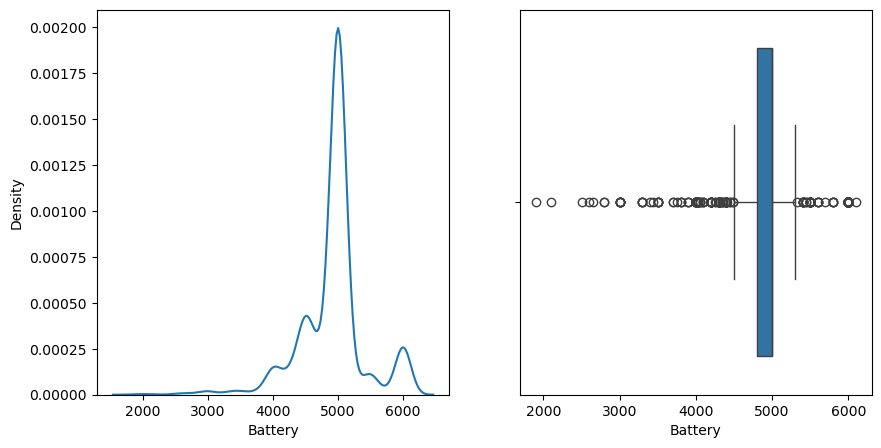

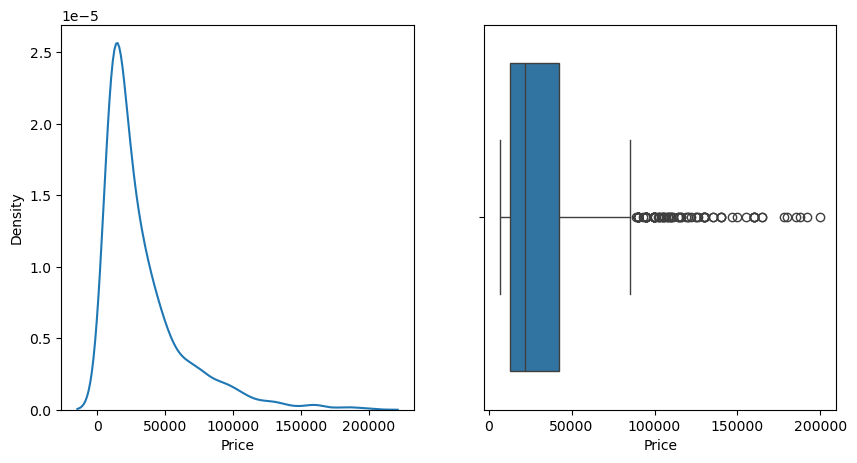

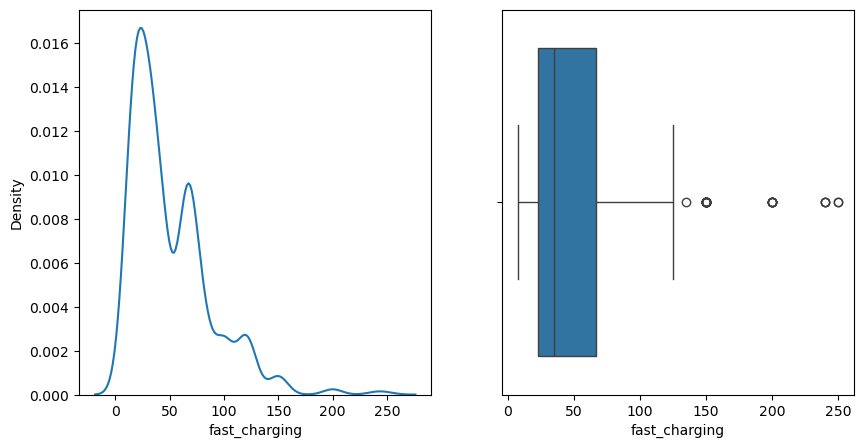

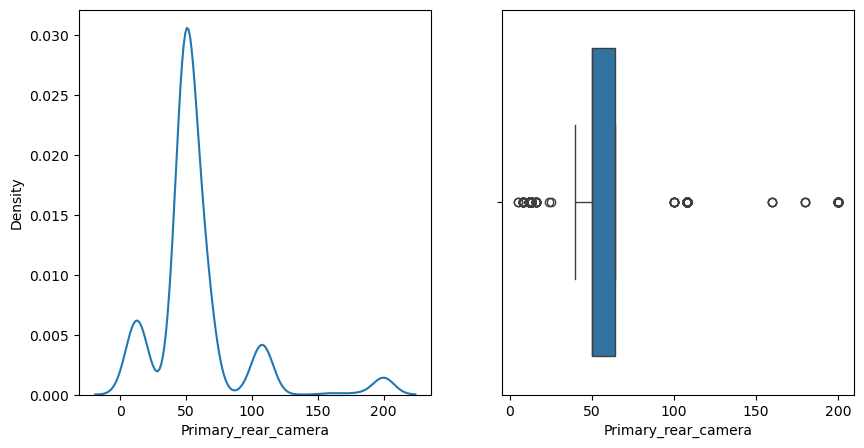

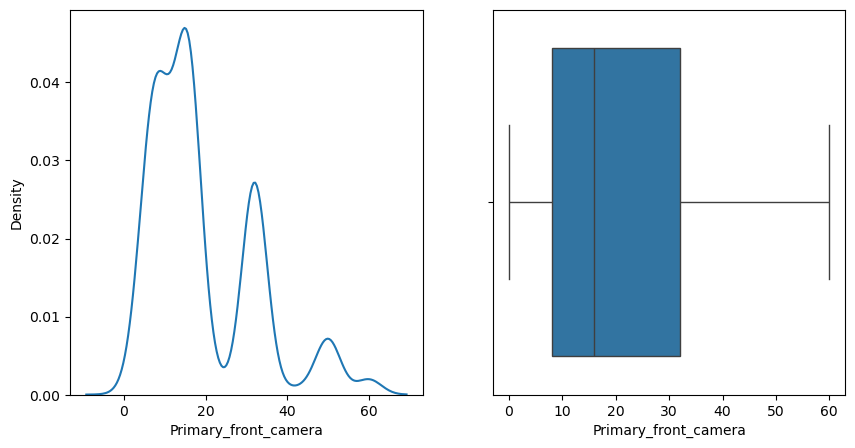

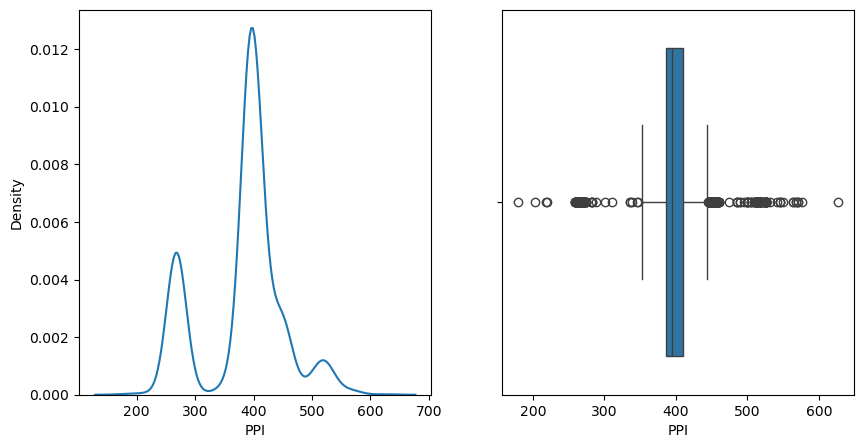

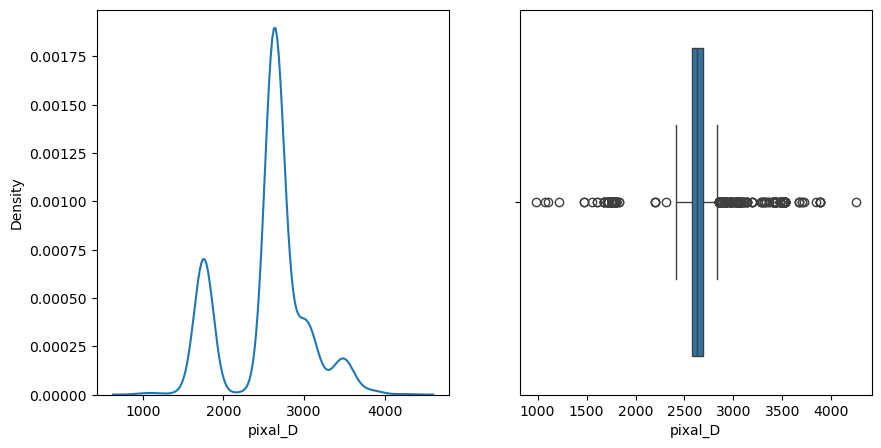

'\nSpec score rigth skewness\nprice and fast charging lift skewness\n'

In [12]:
for i in n_col:
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(df,x=i)
    plt.subplot(1,2,2)
    sns.boxplot(df,x=i)
    plt.show()

"""
Spec score rigth skewness
price and fast charging lift skewness
"""

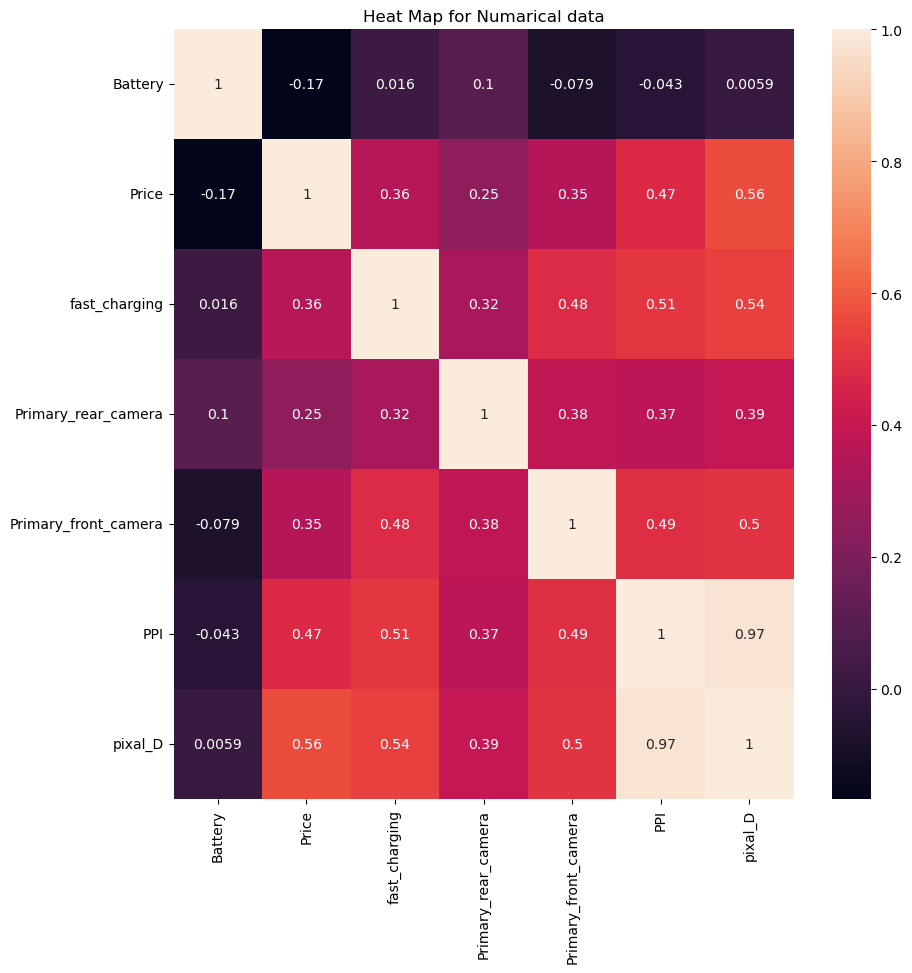

In [13]:
plt.figure(figsize=(10,10))
sns.heatmap(df[n_col].corr(),annot=True)
plt.title("Heat Map for Numarical data")
plt.show()


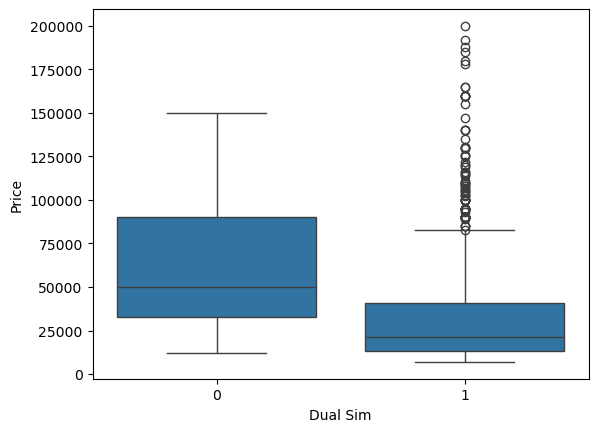

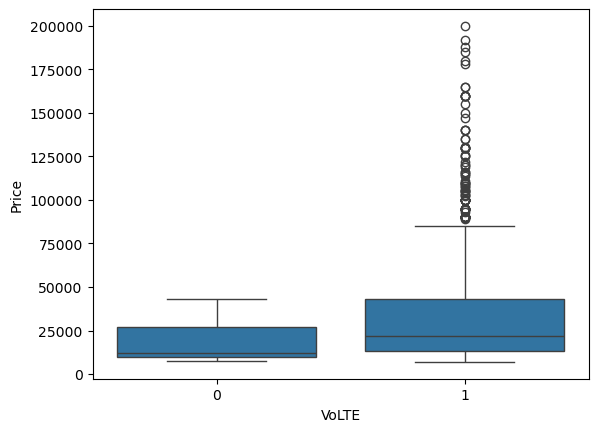

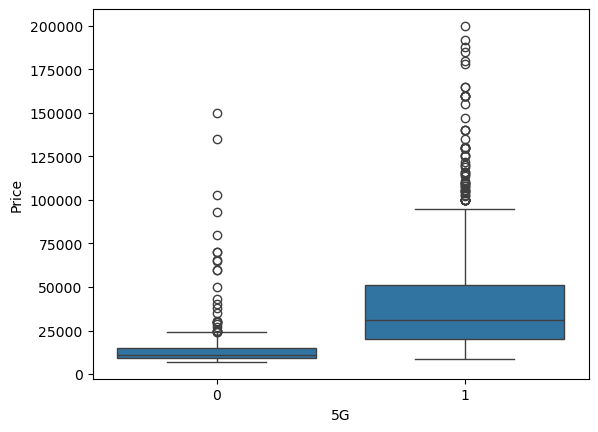

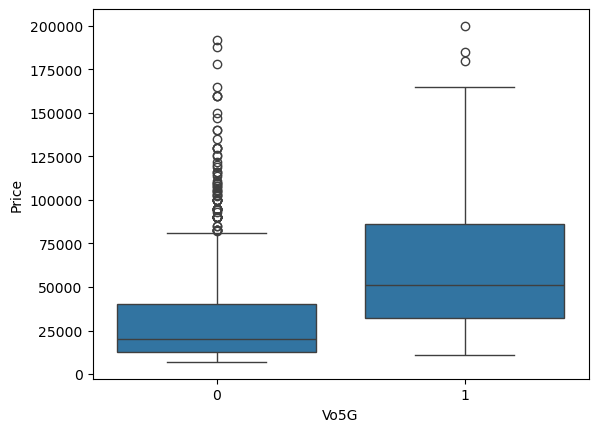

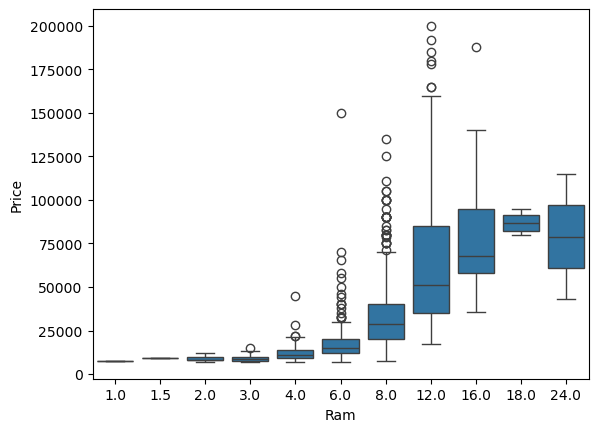

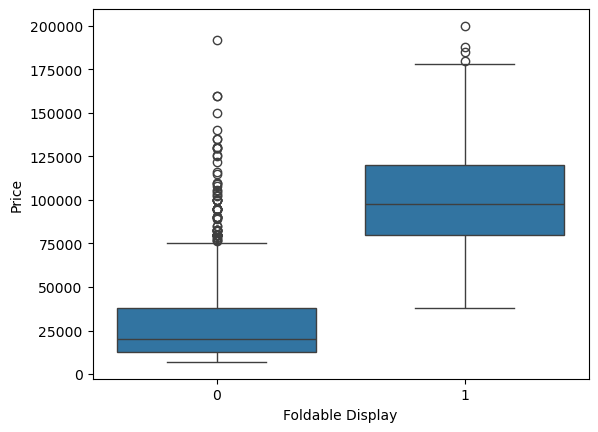

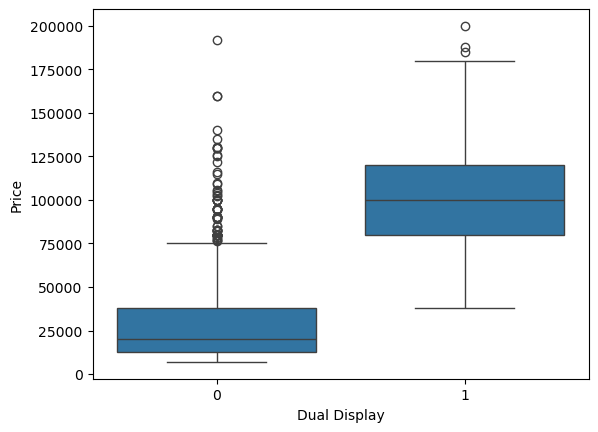

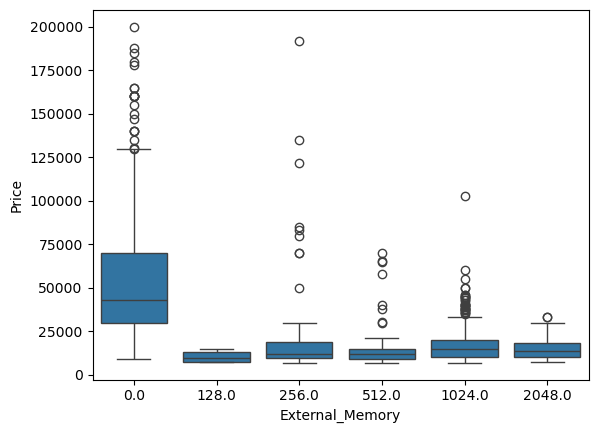

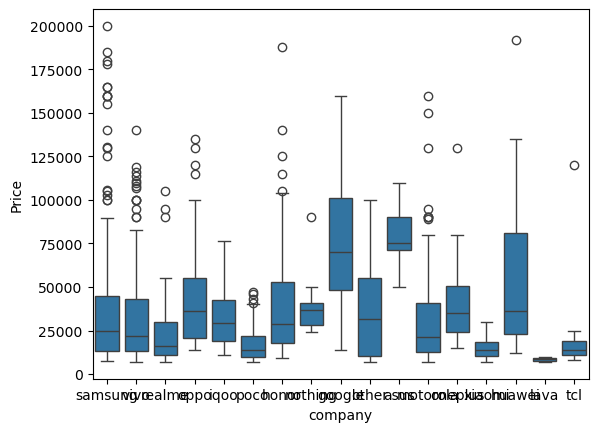

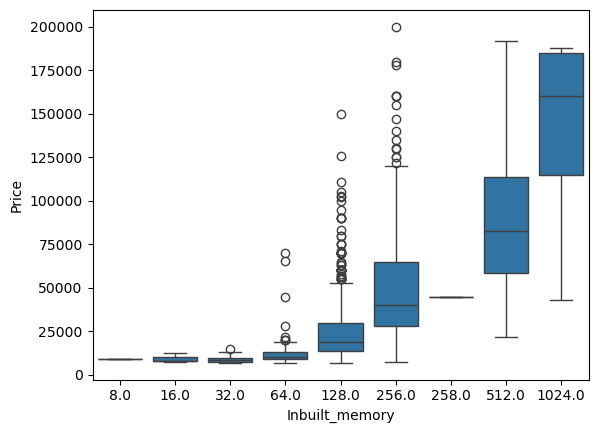

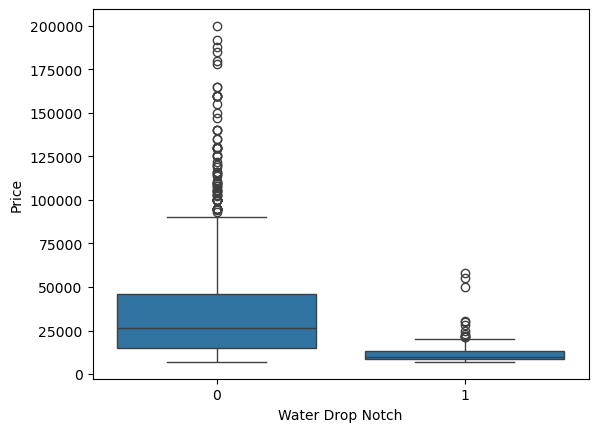

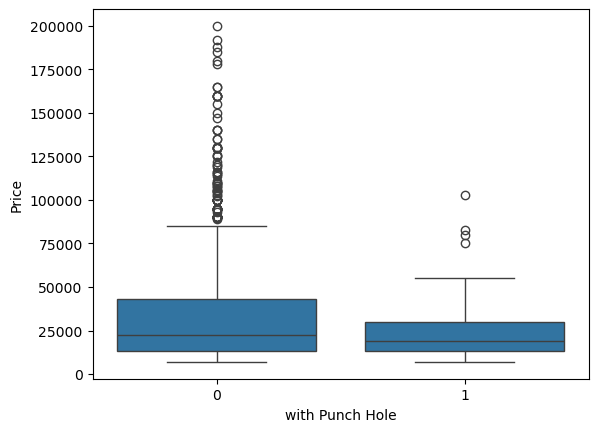

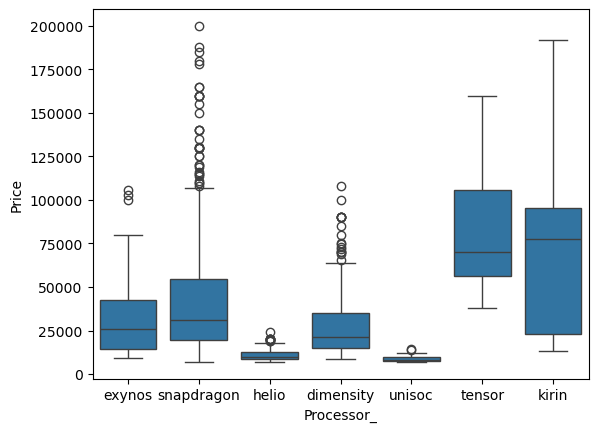

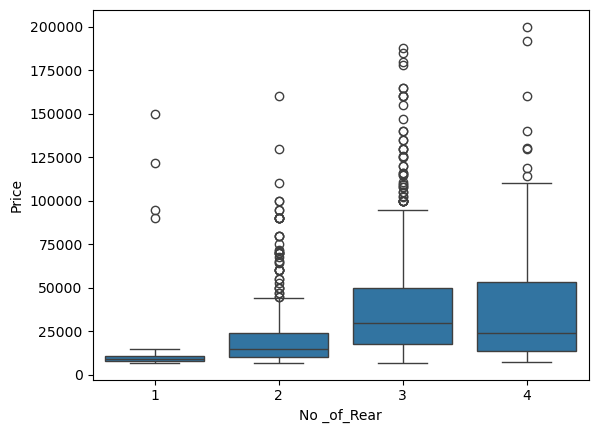

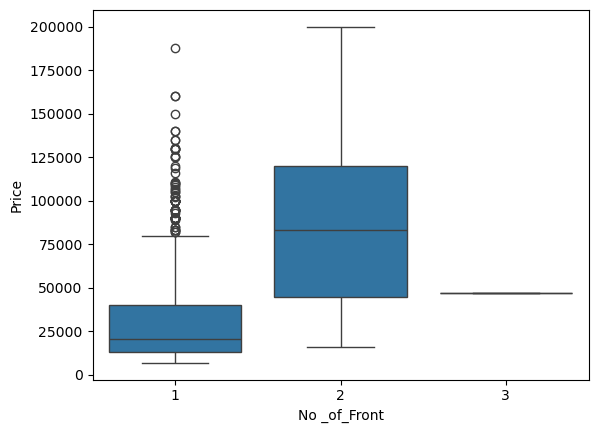

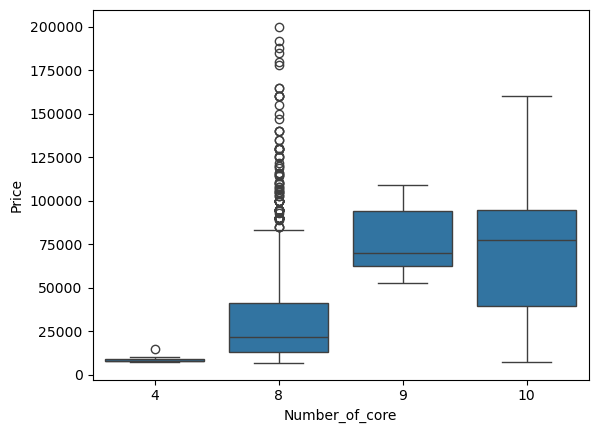

In [14]:
for i in col:
    sns.boxplot(df,y='Price',x=i)
    plt.show()

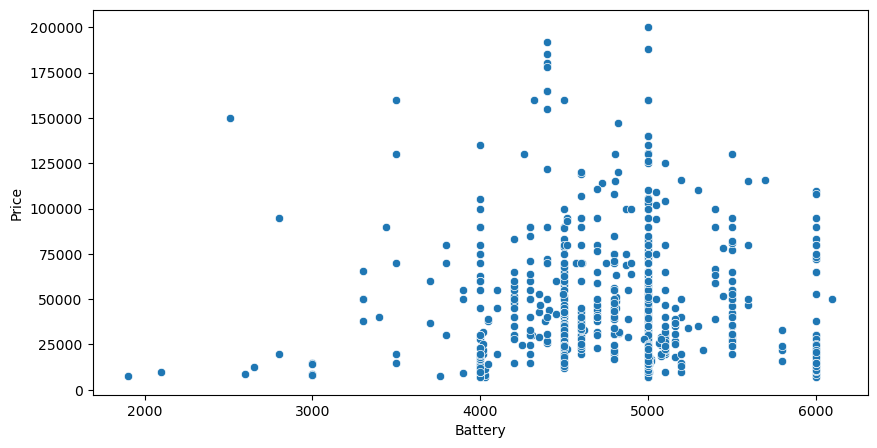

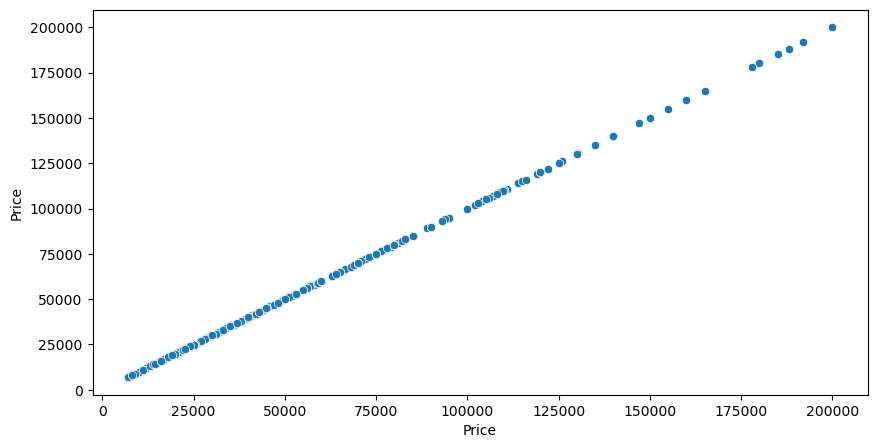

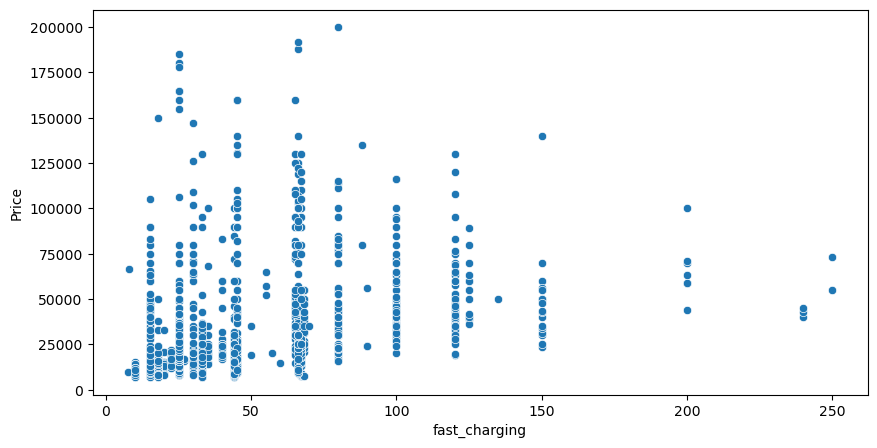

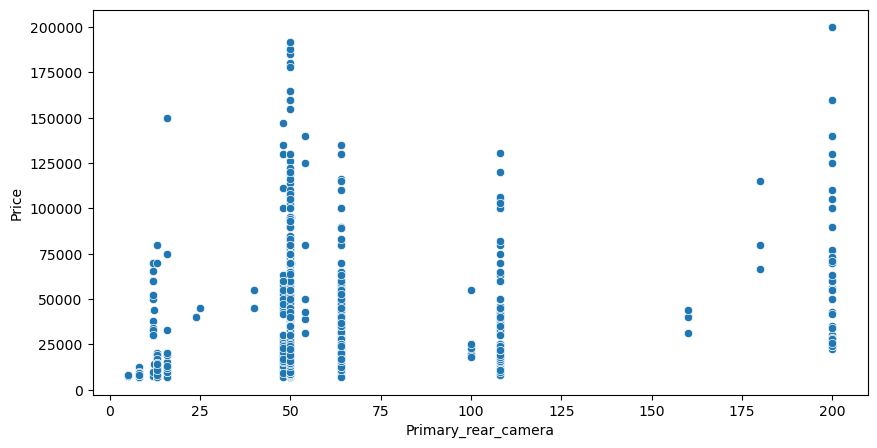

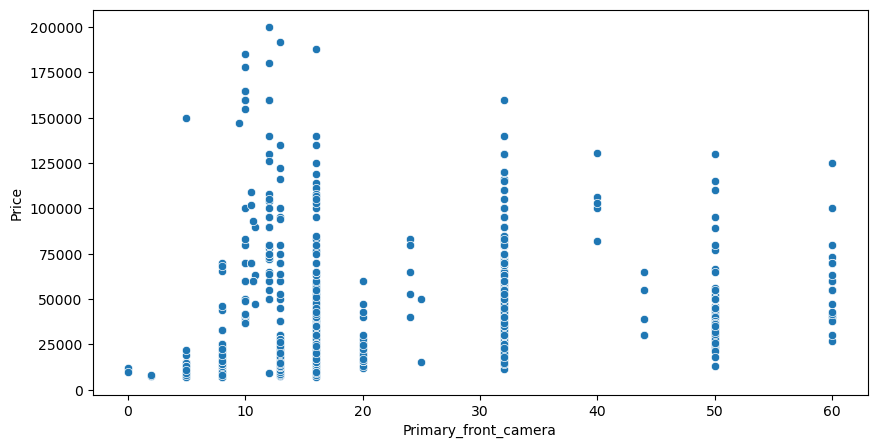

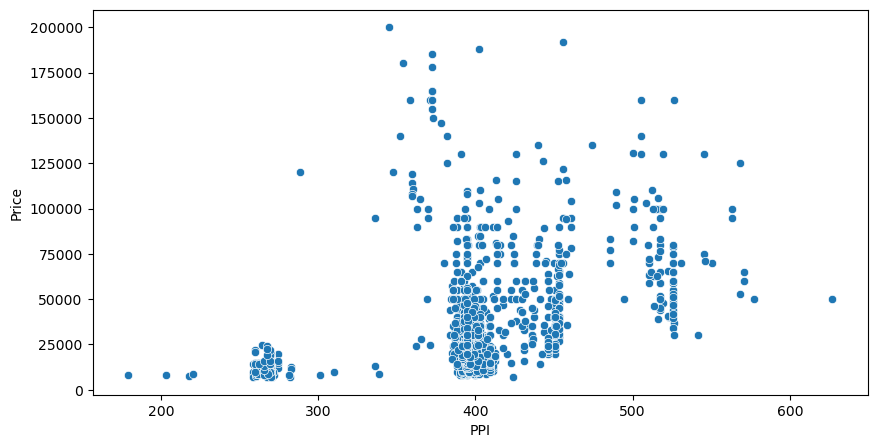

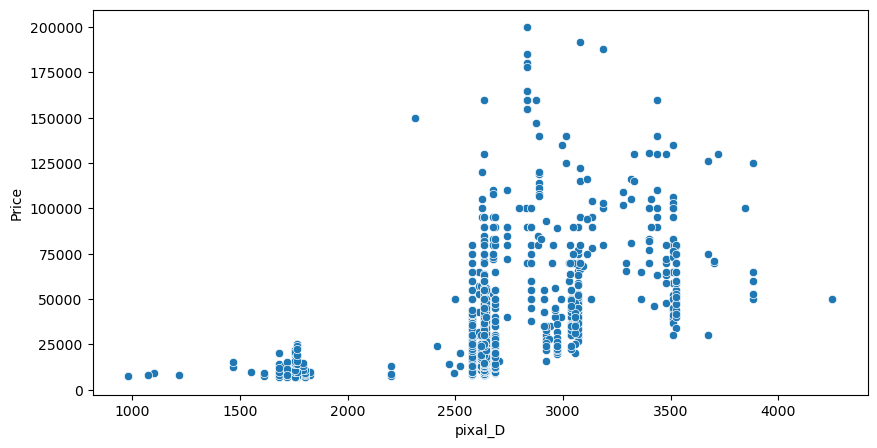

In [15]:
for i in n_col:
    plt.figure(figsize=(10,5))
    sns.scatterplot(df,x=i,y="Price")
    plt.show()


In [16]:
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
import pickle

In [17]:
x=df.drop('Price',axis=1)
y=np.log10(df['Price'])
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=40)

In [18]:
ct=ColumnTransformer([('company',OneHotEncoder(drop='first'),['company']),
                      ('processor',OneHotEncoder(drop='first'),['Processor_']),
                      ('box cox',PowerTransformer(standardize=True),
                       ['Ram','Battery','External_Memory','Inbuilt_memory','fast_charging',
                                                  'No _of_Rear','No _of_Front','Primary_rear_camera','Primary_front_camera',
                                                 'Number_of_core','pixal_D','PPI'])],remainder='passthrough')


In [19]:
lr=LinearRegression()

In [20]:
pipe=Pipeline([('tranformetion',ct),('resression',lr)])
model=pipe.fit(x_train,y_train)

In [21]:
model.score(x_train,y_train)

0.881821962046553

In [22]:
model.score(x_test,y_test)

0.8906416460053688

In [23]:
with open('samart_phone_price.pkl', 'wb') as file:
    pickle.dump(model, file)
with open('df.pkl', 'wb') as file:
    pickle.dump(df, file)
